In [4]:
import geopandas as gpd
import pandas as pd
import pysal as ps
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pycrs
#import rtree

Se crean las funciones que permiten cargar los archivos con las distintas fuentes de datos

In [5]:
#función que carga los archivos shp de Censo del INE en 2011
def cargarFicheroINE(filename):
    print('Loading ine file: ' + filename)
    df_INE=gpd.read_file(filename, encoding='utf8')
    # eliminamos columunas que no se van a utilizar
    print('loaded')
    print('changing projection to 4326')
    df_INE = df_INE.drop(['NCA','NMUN','NPRO','CCA','CNUT0','CNUT1','CNUT2','CNUT3','CUDIS','CUMUN','CLAU2','OBS','Shape_Leng','Shape_area','Shape_len','OBJECTID'],
                         axis=1).to_crs({'init':'epsg:4326'})
    return df_INE

In [6]:
#Se carga el archivo dado por Madiva con las valoraciones (valores de mediados de 2016)

def madivacensusTrackGenerator(filename):
    print('Loading madiva file: ' + filename)
    df=pd.read_csv(filename, sep=",", decimal=",")
    print('Loaded')
    df['censusTrack'] = df['codproine'].apply(lambda x: "%02d" % + x) + \
                        df['codmunine'].apply(lambda x: "%03d" % + x) + \
                        df['coddistcensal'].apply(lambda x: "%02d" % + x) + \
                        df['codsecccensal'].apply(lambda x: "%03d" % + x)
    print('censusTrack added')
    
    return df[['censusTrack', 
               'euros_m2_residencial_g']]


In [7]:
def filterbycodINE(df, province, municipio ):
    return df[(df['CPRO']==province) & (df['CMUN']==municipio)]

In [8]:
# MAIN EXECUTION

ine_file = '/us/u519914/lava_iniciative/data/madiva/data/INE/SECC_CPV_E_20111101_01_R_INE.shp'
madiva_file = '/us/u519914/lava_iniciative/data/madiva/data/madiva_geo/madiva_geo.csv'


df_ine = cargarFicheroINE(ine_file)
df_madiva = madivacensusTrackGenerator(madiva_file)
df_mixed = pd.merge(df_ine,df_madiva,how='inner',left_on='CUSEC',right_on='censusTrack')

df_madrid = filterbycodINE(df_mixed,'28','079')
df_barcelona = filterbycodINE(df_mixed,'08','019')
df_all = pd.concat([df_madrid,df_barcelona])

print 'executed'

Loading ine file: /us/u519914/lava_iniciative/data/madiva/data/INE/SECC_CPV_E_20111101_01_R_INE.shp
loaded
changing projection to 4326
Loading madiva file: /us/u519914/lava_iniciative/data/madiva/data/madiva_geo/madiva_geo.csv
Loaded
censusTrack added
executed


In [9]:
df_all.dtypes

CDIS                       object
CMUN                       object
CPRO                       object
CSEC                       object
CUSEC                      object
geometry                   object
censusTrack                object
euros_m2_residencial_g    float64
dtype: object

In [10]:
#ponemos la proyección de INE a df_all para poder pasarla a archivo shp
df_all=df_all.to_crs({'init': 'epsg:25830'})
df_all.crs

{'init': 'epsg:25830'}

In [11]:
# definimos las proyección del INE
prj='PROJCS["ETRS_1989_UTM_Zone_30N",GEOGCS["GCS_ETRS_1989",DATUM["D_ETRS_1989",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-3.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]'

In [16]:
#creamos un archivo shp para los datos de INE + Madiva que recogen las valoraciones ya por sscc
df_all.to_file('/us/u019055/lava_iniciative/data/salida_geopandas/ine_madiva.shp', driver='ESRI Shapefile', crs_wkt=prj)

ValueError: Null layer

In [12]:
#partimos de un dataframe que, al menos tiene la censusTrack y geometry

def addingVariableGeoJson(df, file_name, var_name):
    #CONSTANTS 
    crs_4326 = {'init':'epsg:4326','proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True}
    
    #creamos un minidataframe del original para cruzar (campos minimos)
    df_aux=df[['CUSEC','geometry']].to_crs(crs_4326)
    
    #Cargamos el geojson de variables
    var_geojson=gpd.read_file(file_name)
    var_geojson=var_geojson[['name','geometry']]
    var_geojson['name'].fillna('no_name')
    var_geojson.crs=crs_4326
    
    #realizamos la interseccion y agrupamos por sección censal
    df_aux = gpd.sjoin(df_aux,var_geojson,how='left',op='intersects')
    groups = df_aux.groupby(['CUSEC'])['index_right'].count().reset_index(name = var_name)
    df_aux = pd.DataFrame(groups)
    return pd.merge(df,df_aux,how='inner',left_on='CUSEC',right_on='CUSEC')


In [13]:
#vemos un listado de las variables explicativas (que son de localización) en el archivo

from os import listdir
ruta= '/us/e001255/lava_iniciative/data/madiva/data/explicativas/'
for path in listdir(ruta):  
       print path

In [14]:
#se agregan las variables explicativas de localización a la info fr INE+Madiva

from os import listdir
from os.path import join

ruta= '/us/e001255/lava_iniciative/data/madiva/data/explicativas/'
for path in listdir(ruta):  
    name_file = path.split('.')[0]
    
    if name_file in df_all.columns: 
        df_all = df_all.drop(name_file, 1)
    
    df_all = addingVariableGeoJson(df_all, join(ruta,path), name_file) 
    print("procesado " + name_file)
print ('fin proceso')

fin proceso


In [15]:
# traemos los datos socioeconómicos de INE para unirlos a la matriz con todos los demás datos

ine_censo=pd.read_csv('/us/u519914/lava_iniciative/data/in/datos_ine_censo_final.csv',sep=";",decimal=",")
#ine_censo['id_sscc']=ine_censo['id_sscc'].astype(str)

In [16]:
#Se genera una columna con PRO+MUN+DIST+SEC = id_sscc

def inecensusTrackGenerator(filename):
    print('Loading ine file: ' + filename)
    df=pd.read_csv('/us/u519914/lava_iniciative/data/in/datos_ine_censo_final.csv', sep=";", decimal=",")
    print('Loaded')
    df['id_sscc'] = df['cpro'].apply(lambda x: "%02d" % + x) + \
                        df['cmun'].apply(lambda x: "%03d" % + x) + \
                        df['dist'].apply(lambda x: "%02d" % + x) + \
                        df['secc'].apply(lambda x: "%03d" % + x)
    print('id_sscc added')
    
    return df

In [17]:
ine_censo=inecensusTrackGenerator('/us/u519914/lava_iniciative/data/in/datos_ine_censo_final.csv')

Loading ine file: /us/u519914/lava_iniciative/data/in/datos_ine_censo_final.csv
Loaded
id_sscc added


In [18]:
#2807908002
#2807908004
#2807919001
#2807921015
#801903024
#801905001
ine_censo[ine_censo['id_sscc']=='2807908002']

ccaa  cpro  cmun  dist  secc  pob_tot  hombres  mujeres  < 16 anos  \
29511    13    28    79     8     2      380    190.0    195.0       65.0   

       entre 16 y 64 anos     ...      Viviendas con 8 habitaciones  \
29511               210.0     ...                               NaN   

       Viviendas con 9 o mas habitaciones  Total Hogares  \
29511                                 NaN          150.0   

       Hogares de 1 persona  Hogares de 2 personas  Hogares de 3 personas  \
29511                   NaN                   60.0                    NaN   

       Hogares de 4 personas  Hogares de 5 personas  \
29511                    NaN                    NaN   

       Hogares de 6 o mas personas     id_sscc  
29511                          NaN  2807908002  

[1 rows x 151 columns]

In [19]:
#eliminamos las columnas que no son necesarias
ine_censo=ine_censo.drop(['ccaa','cpro','cmun','dist','secc'], axis=1)

Realizamos agrupación de variables sobre el Dataset del INE

In [20]:
ine_censo.head(5)

pob_tot  hombres  mujeres  < 16 anos  entre 16 y 64 anos  <64 anos  \
0     1460    760.0    695.0      170.0               930.0     360.0   
1     1350    700.0    655.0      150.0               870.0     335.0   
2      765    325.0    445.0       70.0               590.0     105.0   
3     1750    800.0    950.0      335.0              1140.0     275.0   
4     1815    780.0   1035.0      470.0              1120.0     225.0   

   nacidos espana  nacidos eu  nacidos europa_no_eu  nacidos africa  \
0          1300.0       155.0                   0.0             5.0   
1          1270.0        80.0                   0.0             0.0   
2           740.0         NaN                   NaN             NaN   
3          1695.0         0.0                  45.0             0.0   
4          1660.0         0.0                  10.0           145.0   

      ...      Viviendas con 8 habitaciones  \
0     ...                              80.0   
1     ...                              50.0   
2     ...                               NaN   
3     ...                               NaN   
4     ...                               NaN   

   Viviendas con 9 o mas habitaciones  Total Hogares  Hogares de 1 persona  \
0                               100.0          595.0                 140.0   
1                                50.0          550.0                 125.0   
2                                 NaN          295.0                   NaN   
3                                 NaN          650.0                 105.0   
4                                 NaN          610.0                  50.0   

   Hogares de 2 personas  Hogares de 3 personas  Hogares de 4 personas  \
0                  215.0                  120.0                   85.0   
1                  170.0                  145.0                   90.0   
2                   80.0                    NaN                   80.0   
3                  230.0                  105.0                  175.0   
4                  170.0                  180.0                  170.0   

   Hogares de 5 personas  Hogares de 6 o mas personas     id_sscc  
0                   35.0                          0.0  0400101001  
1                   15.0                          0.0  0400201001  
2                    NaN                          NaN  0400301001  
3                   30.0                          0.0  0400301002  
4                   20.0                         15.0  0400301003  

[5 rows x 146 columns]

In [21]:
ine_censo.dtypes

pob_tot                                                int64
hombres                                              float64
mujeres                                              float64
< 16 anos                                            float64
entre 16 y 64 anos                                   float64
<64 anos                                             float64
nacidos espana                                       float64
nacidos eu                                           float64
nacidos europa_no_eu                                 float64
nacidos africa                                       float64
nacidos latam                                        float64
nacidos norte america                                float64
nacidos asia                                         float64
nacidos oceania                                      float64
nacionalidad espanola  nacidos en Espana             float64
nacionalidad extranjera  nacidos en Espana           float64
nacionalidad espanola  n

In [22]:
#Definimos las varibles de sexo sobre el total de la población. La variable mujeres no se incluye ya que ambas suman el 100%
hombres_perc=ine_censo['hombres']/ine_censo['pob_tot']

In [23]:
#Generamos un nuevo Dataframe con las nuevas columnas del Ine que vamos generando
ine_clean=pd.DataFrame({'hombres_perc':hombres_perc})

In [24]:
#Definimos las varibles de edad sobre el total de la población.
edad_16anos_perc=ine_censo['< 16 anos']/ine_censo['pob_tot']
edad_16_y_64_anos_perc=ine_censo['entre 16 y 64 anos']/ine_censo['pob_tot']
edad_64_anos_perc=ine_censo['<64 anos']/ine_censo['pob_tot']

In [25]:
#Añadimos las nuevas variables al Dataframe
ine_clean['edad_16anos_perc']=edad_16anos_perc
ine_clean['edad_16_y_64_anos_perc']=edad_16_y_64_anos_perc
ine_clean['edad_64_anos_perc']=edad_64_anos_perc

In [26]:
ine_clean.head(5)

hombres_perc  edad_16anos_perc  edad_16_y_64_anos_perc  edad_64_anos_perc
0      0.520548          0.116438                0.636986           0.246575
1      0.518519          0.111111                0.644444           0.248148
2      0.424837          0.091503                0.771242           0.137255
3      0.457143          0.191429                0.651429           0.157143
4      0.429752          0.258953                0.617080           0.123967

In [27]:
#Definimos las varibles de nacionalidad sobre el total de la población y la añado al Dataframe.
#Las Personas nacionalidad extranjera no se incluyen ya que suman el 100% con esta varible

nacionalidad_espanola_perc=ine_censo['Personas nacionalidad espanola']/ine_censo['pob_tot']
ine_clean['nacionalidad_espanola_perc']=nacionalidad_espanola_perc

In [28]:
#Definimos las varibles de estado civil sobre el total de la población y la añado al Dataframe.
casados_perc=ine_censo['casados']/ine_censo['pob_tot']
#no_casados_perc=(ine_censo['separados']+ine_censo['divorciados']+ine_censo['viudos']+ine_censo['solteros'])/ine_censo['pob_tot']
ine_clean['casados_perc']=casados_perc
#ine_clean['no_casados_perc']=no_casados_perc

In [29]:
ine_clean.head(5)

hombres_perc  edad_16anos_perc  edad_16_y_64_anos_perc  edad_64_anos_perc  \
0      0.520548          0.116438                0.636986           0.246575   
1      0.518519          0.111111                0.644444           0.248148   
2      0.424837          0.091503                0.771242           0.137255   
3      0.457143          0.191429                0.651429           0.157143   
4      0.429752          0.258953                0.617080           0.123967   

   nacionalidad_espanola_perc  casados_perc  
0                    0.897260      0.520548  
1                    0.940741      0.514815  
2                    0.928105      0.444444  
3                    0.968571      0.502857  
4                    0.914601      0.432507

In [30]:
#Definimos las varibles de estudios sobre el total de la población y la añado al Dataframe.
sin_estudios_perc=(ine_censo['analfabetos']+ine_censo['sin estudios'])/ine_censo['pob_tot']
estudios_primer_grado_perc=ine_censo['estudios primer grado']/ine_censo['pob_tot']
estudios_segundo_grado_perc=ine_censo['estudios segundo grado']/ine_censo['pob_tot']
estudios_tercer_grado_perc=ine_censo['estudios tercer grado']/ine_censo['pob_tot']
ine_clean['sin_estudios_perc']=sin_estudios_perc
ine_clean['estudios_primer_grado_perc']=estudios_primer_grado_perc
ine_clean['estudios_segundo_grado_perc']=estudios_primer_grado_perc
ine_clean['estudios_tercer_grado_perc']=estudios_primer_grado_perc

In [31]:
#Definimos las varibles de tipo de vivienda sobre el total viviendas y la añado al Dataframe.
viviendas_principales_perc=ine_censo['Viviendas Principales']/ine_censo['total viviendas']
viviendas_secundarias_perc=ine_censo['Viviendas Secundarias']/ine_censo['total viviendas']
viviendas_vacias_perc=ine_censo['Viviendas Vacias']/ine_censo['total viviendas']
ine_clean['viviendas_principales_perc']=viviendas_principales_perc
ine_clean['viviendas_secundarias_perc']=viviendas_secundarias_perc
ine_clean['viviendas_vacias_perc']=viviendas_vacias_perc


In [32]:
#Definimos las varibles de alquiler o propiedad de la vivienda sobre el total viviendas principales y la añado al Dataframe.
viviendas_propiedad_perc=(ine_censo['Viviendas en propiedad, por compra, totalmente pagada']+
                          ine_censo['Viviendas en propiedad, por compra, totalmente pagada']+
                          ine_censo['Viviendas en propiedad, por herencia o donacion'])/ine_censo['Viviendas Principales']
viviendas_alquiler_perc=ine_censo['Viviendas en alquiler']/ine_censo['Viviendas Principales']
viviendas_cedidas_perc=(ine_censo['Viviendas cedida gratis o a bajo precio']+
                        ine_censo['Viviendas en otro tipo de regimen de tenencia'])/ine_censo['Viviendas Principales']
ine_clean['viviendas_propiedad_perc']=viviendas_propiedad_perc
ine_clean['viviendas_alquiler_perc']=viviendas_alquiler_perc
ine_clean['viviendas_cedidas_perc']=viviendas_cedidas_perc

In [33]:
#Definimos las varibles de metros de la vivienda sobre el total viviendas principales y la añado al Dataframe.

viviendas_menos_45m2_perc=(ine_censo['Viviendas de menos de 30m2']+
                        ine_censo['Viviendas entre 30-45 m2'])/ine_censo['Viviendas Principales']
viviendas_menos_75m2_perc=(ine_censo['Viviendas entre 46-60 m2']+
                        ine_censo['Viviendas entre 61-75 m2'])/ine_censo['Viviendas Principales']
viviendas_menos_105m2_perc=(ine_censo['Viviendas entre 76-90 m2']+
                        ine_censo['Viviendas entre 91-105 m2'])/ine_censo['Viviendas Principales']
viviendas_menos_150m2_perc=(ine_censo['Viviendas entre 106-120 m2']+
                        ine_censo['Viviendas entre 121-150 m2'])/ine_censo['Viviendas Principales']
viviendas_mas_150m2_perc=(ine_censo['Viviendas entre 151-180 m2']+
                        ine_censo['Viviendas de mas de 180 m2'])/ine_censo['Viviendas Principales']
ine_clean['viviendas_menos_45m2_perc']=viviendas_menos_45m2_perc
ine_clean['viviendas_menos_75m2_perc']=viviendas_menos_75m2_perc
ine_clean['viviendas_menos_105m2_perc']=viviendas_menos_105m2_perc
ine_clean['viviendas_menos_150m2_perc']=viviendas_menos_150m2_perc
ine_clean['viviendas_mas_150m2_perc']=viviendas_mas_150m2_perc

In [34]:
#Definimos las variables de nºhabitaciones de la vivienda sobre el total hogares y la añado al Dataframe.

viviendas_menos_2habitaciones_perc=(ine_censo['Viviendas con 1 habitacion']+
                                    ine_censo['Viviendas con 2 habitaciones'])/ine_censo['Viviendas Principales']
viviendas_menos_4habitaciones_perc=(ine_censo['Viviendas con 3 habitaciones']+
                        ine_censo['Viviendas con 4 habitaciones'])/ine_censo['Viviendas Principales']
viviendas_mas_4habitaciones_perc=(ine_censo['Viviendas con 5 habitaciones']+
                                  ine_censo['Viviendas con 6 habitaciones']+
                                  ine_censo['Viviendas con 7 habitaciones']+
                                  ine_censo['Viviendas con 8 habitaciones']+
                                  ine_censo['Viviendas con 9 o mas habitaciones'])/ine_censo['Viviendas Principales']

ine_clean['viviendas_menos_2habitaciones_perc']=viviendas_menos_2habitaciones_perc
ine_clean['viviendas_menos_4habitaciones_perc']=viviendas_menos_4habitaciones_perc
ine_clean['viviendas_mas_4habitacione_perc']=viviendas_mas_4habitaciones_perc

In [35]:
#Definimos las varibles tipos de hogares sobre el total viviendas principales y la añado al Dataframe.

hogares_unifamiliares_perc=ine_censo['Hogares de 1 persona']/ine_censo['Viviendas Principales']
hogares_parejas_perc=ine_censo['Hogares de 2 personas']/ine_censo['Viviendas Principales']
hogares_familias_perc=(ine_censo['Hogares de 3 personas']+
                       ine_censo['Hogares de 4 personas']+
                       ine_censo['Hogares de 5 personas']+
                       ine_censo['Hogares de 6 o mas personas'])/ine_censo['Viviendas Principales']

ine_clean['hogares_unifamiliares_perc']=hogares_unifamiliares_perc
ine_clean['hogares_parejas_perc']=hogares_parejas_perc
ine_clean['hogares_familias_perc']=hogares_familias_perc

In [36]:
ine_clean.dtypes

hombres_perc                          float64
edad_16anos_perc                      float64
edad_16_y_64_anos_perc                float64
edad_64_anos_perc                     float64
nacionalidad_espanola_perc            float64
casados_perc                          float64
sin_estudios_perc                     float64
estudios_primer_grado_perc            float64
estudios_segundo_grado_perc           float64
estudios_tercer_grado_perc            float64
viviendas_principales_perc            float64
viviendas_secundarias_perc            float64
viviendas_vacias_perc                 float64
viviendas_propiedad_perc              float64
viviendas_alquiler_perc               float64
viviendas_cedidas_perc                float64
viviendas_menos_45m2_perc             float64
viviendas_menos_75m2_perc             float64
viviendas_menos_105m2_perc            float64
viviendas_menos_150m2_perc            float64
viviendas_mas_150m2_perc              float64
viviendas_menos_2habitaciones_perc

In [3]:
##Generamos los cuartiles para todas las variables agregadas del INE

q_hombres_perc=pd.qcut(ine_clean['hombres_perc'], 4, labels=[0,1,2,3])
q_edad_16anos_perc=pd.qcut(ine_clean['edad_16anos_perc'], 4, labels=[0,1,2,3])
q_edad_16_y_64_anos_perc=pd.qcut(ine_clean['edad_16_y_64_anos_perc'], 4, labels=[0,1,2,3])
q_edad_64_anos_perc=pd.qcut(ine_clean['edad_64_anos_perc'], 4, labels=[0,1,2,3])
q_nacionalidad_espanola_perc=pd.qcut(ine_clean['nacionalidad_espanola_perc'], 4, labels=[0,1,2,3])
q_casados_perc=pd.qcut(ine_clean['casados_perc'], 4, labels=[0,1,2,3])

q_sin_estudios_perc=pd.qcut(ine_clean['sin_estudios_perc'], 4, labels=[0,1,2,3])
q_estudios_primer_grado_perc=pd.qcut(ine_clean['estudios_primer_grado_perc'], 4, labels=[0,1,2,3])
q_estudios_segundo_grado_perc=pd.qcut(ine_clean['estudios_segundo_grado_perc'], 4, labels=[0,1,2,3])
q_estudios_tercer_grado_perc=pd.qcut(ine_clean['estudios_tercer_grado_perc'], 4, labels=[0,1,2,3])

q_viviendas_principales_perc=pd.qcut(ine_clean['viviendas_principales_perc'], 4, labels=[0,1,2,3])
q_viviendas_secundarias_perc=pd.qcut(ine_clean['viviendas_secundarias_perc'], 4, labels=[0,1,2,3])
q_viviendas_vacias_perc=pd.qcut(ine_clean['viviendas_vacias_perc'], 4, labels=[0,1,2,3])
q_viviendas_propiedad_perc=pd.qcut(ine_clean['viviendas_propiedad_perc'], 4, labels=[0,1,2,3])
q_viviendas_alquiler_perc=pd.qcut(ine_clean['viviendas_alquiler_perc'], 4, labels=[0,1,2,3])
q_viviendas_cedidas_perc=pd.qcut(ine_clean['viviendas_cedidas_perc'], 4, labels=[0,1,2,3])

q_viviendas_menos_45m2_perc=pd.qcut(ine_clean['viviendas_menos_45m2_perc'], 4, labels=[0,1,2,3])
q_viviendas_menos_75m2_perc=pd.qcut(ine_clean['viviendas_menos_75m2_perc'], 4, labels=[0,1,2,3])
q_viviendas_menos_105m2_perc=pd.qcut(ine_clean['viviendas_menos_105m2_perc'], 4, labels=[0,1,2,3])
q_viviendas_menos_150m2_perc=pd.qcut(ine_clean['viviendas_menos_150m2_perc'], 4, labels=[0,1,2,3])
q_viviendas_mas_150m2=pd.qcut(ine_clean['viviendas_mas_150m2'], 4, labels=[0,1,2,3])

q_viviendas_menos_2habitaciones_perc=pd.qcut(ine_clean['viviendas_menos_2habitaciones_perc'], 4, labels=[0,1,2,3])
q_viviendas_menos_4habitaciones_perc=pd.qcut(ine_clean['viviendas_menos_4habitaciones_perc'], 4, labels=[0,1,2,3])
q_viviendas_mas_4habitacione_perc=pd.qcut(ine_clean['viviendas_mas_4habitacione_perc'], 4, labels=[0,1,2,3])

q_hogares_unifamiliares_perc=pd.qcut(ine_clean['hogares_unifamiliares_perc'], 4, labels=[0,1,2,3])
q_hogares_parejas_perc=pd.qcut(ine_clean['hogares_parejas_perc'], 4, labels=[0,1,2,3])
q_hogares_familias_perc=pd.qcut(ine_clean['hogares_familias_perc'], 4, labels=[0,1,2,3])


NameError: name 'pd' is not defined

In [140]:
ine_clean['q_hombres_perc']=q_hombres_perc

hombres_perc  edad_16anos_perc  edad_16_y_24_anos_perc  edad_64_anos_perc  \
0       0.520548          0.116438                0.636986           0.246575   
1       0.518519          0.111111                0.644444           0.248148   
2       0.424837          0.091503                0.771242           0.137255   
3       0.457143          0.191429                0.651429           0.157143   
4       0.429752          0.258953                0.617080           0.123967   
5       0.541761          0.153499                0.785553           0.058691   
6       0.488189          0.194226                0.671916           0.133858   
7       0.463415          0.142276                0.739837           0.113821   
8       0.400000          0.097143                0.731429           0.165714   
9       0.549521          0.134185                0.801917           0.063898   
10      0.612903          0.264516                0.625806           0.109677   
11      0.536913          0.241611                0.496644           0.255034   
12      0.527378          0.256484                0.608069           0.132565   
13      0.475570          0.260586                0.644951           0.094463   
14      0.520101          0.095477                0.766332           0.138191   
15      0.426230          0.122951                0.565574           0.311475   
16      0.450172          0.175258                0.649485           0.175258   
17      0.609108          0.168880                0.724858           0.108159   
18      0.510067          0.100671                0.530201           0.369128   
19      0.489051          0.087591                0.613139           0.299270   
20      0.460396          0.118812                0.693069           0.188119   
21      0.565957          0.197872                0.725532           0.076596   
22      0.490033          0.222591                0.636213           0.141196   
23      0.557252          0.305344                0.614504           0.080153   
24      0.490066          0.072848                0.589404           0.337748   
25      0.482474          0.080412                0.606186           0.311340   
26      0.521978          0.115385                0.642857           0.241758   
27      0.536000          0.104000                0.592000           0.304000   
28      0.500000          0.062500                0.687500           0.250000   
29      0.503650          0.124088                0.671533           0.204380   
..           ...               ...                     ...                ...   
70      0.455357          0.035714                0.741071           0.214286   
71      0.517900          0.169451                0.751790           0.078759   
72      0.485623          0.115016                0.798722           0.086262   
73      0.463115          0.260246                0.649590           0.090164   
74      0.443459          0.199557                0.667406           0.133038   
75      0.496169          0.191571                0.712644           0.097701   
76      0.463087          0.134228                0.657718           0.208054   
77      0.464865          0.167568                0.572973           0.259459   
78      0.464419          0.142322                0.760300           0.101124   
79      0.460177          0.176991                0.557522           0.265487   
80      0.444162          0.101523                0.703046           0.195431   
81      0.503401          0.251701                0.534014           0.210884   
82      0.531792          0.202312                0.601156           0.196532   
83      0.443425          0.140673                0.697248           0.159021   
84      0.455847          0.152745                0.732697           0.114558   
85      0.523573          0.225806                0.630273           0.143921   
86      0.480519          0.264069                0.575758           0.160173   
87      0.422222          0.293333 

In [ ]:
###########FIN LIMPIEZA Y AGREGACIÓN DATOS INE

In [53]:
# Añadimos las variables socioeconómicas
mat_all=pd.merge(df_all,ine_censo,how='left',left_on='CUSEC',right_on='id_sscc')

In [58]:
mat_all[mat_all['id_sscc']=='2807908002']

CDIS CMUN CPRO CSEC       CUSEC  \
774   08  079   28  002  2807908002   

                                              geometry censusTrack  \
774  POLYGON ((432028.2736 4494540.7093, 432043.237...  2807908002   

     euros_m2_residencial_g  bibliotecas  bomberos     ...      \
774             2546.063316            0         0     ...       

     Viviendas con 8 habitaciones  Viviendas con 9 o mas habitaciones  \
774                           NaN                                 NaN   

     Total Hogares  Hogares de 1 persona  Hogares de 2 personas  \
774          150.0                   NaN                   60.0   

     Hogares de 3 personas  Hogares de 4 personas  Hogares de 5 personas  \
774                    NaN                    NaN                    NaN   

     Hogares de 6 o mas personas     id_sscc  
774                          NaN  2807908002  

[1 rows x 172 columns]

In [54]:
mat_all.to_csv('/us/e001255/lava_iniciative/data/salida_geopandas/rawinputdata_nocomercios.csv', sep=";", decimal=",")

In [54]:
mat_all.columns

Index([                              u'CDIS',
                                     u'CMUN',
                                     u'CPRO',
                                     u'CSEC',
                                    u'CUSEC',
                                 u'geometry',
                              u'censusTrack',
                   u'euros_m2_residencial_g',
                              u'bibliotecas',
                                 u'bomberos',
       ...
             u'Viviendas con 7 habitaciones',
             u'Viviendas con 8 habitaciones',
       u'Viviendas con 9 o mas habitaciones',
                            u'Total Hogares',
                     u'Hogares de 1 persona',
                    u'Hogares de 2 personas',
                    u'Hogares de 3 personas',
                    u'Hogares de 4 personas',
                    u'Hogares de 5 personas',
              u'Hogares de 6 o mas personas'],
      dtype='object', length=172)

In [13]:
#convertimos todos los campos con NA en ceros
#mat_all.fillna(0)
#mat_all.replace(0,"")


In [14]:
# traemos los datos de comercios (comprobar el separador y el decimal)
comercios=pd.read_csv('/us/u519914/lava_iniciative/data/economic_data.csv',sep=";",decimal=".")

In [17]:
#generamos la suma del total de operaciones y de importes
comercios.dtypes

ssccs         int64
1.0           int64
2.0           int64
3.0           int64
4.0           int64
5.0           int64
6.0           int64
7.0           int64
8.0           int64
9.0           int64
10.0          int64
11.0          int64
12.0          int64
13.0          int64
14.0          int64
15.0          int64
1.0_imp     float64
2.0_imp     float64
3.0_imp     float64
4.0_imp     float64
5.0_imp     float64
6.0_imp     float64
7.0_imp     float64
8.0_imp     float64
9.0_imp     float64
10.0_imp    float64
11.0_imp    float64
12.0_imp    float64
13.0_imp    float64
14.0_imp    float64
15.0_imp    float64
dtype: object

In [23]:
#se generan 2 columnas que recojan los totales del volumen de trabsacciones y de los importes
comercios["Tot_op"]=comercios.iloc[:,1:16].sum(axis=1)
comercios["Tot_imp"]=comercios.iloc[:,16:31].sum(axis=1)

In [25]:
mat_final=pd.merge(mat_all,comercios,how='left',left_on='CUSEC',right_on='ssccs')

In [19]:
mat_final.to_csv('/us/u519914/lava_iniciative/data/salida_geopandas/rawinputdata.csv', sep=";", decimal=",")

In [28]:
comercios['ssccs'].head(5)

0    801901001
1    801901002
2    801901003
3    801901004
4    801901005
Name: ssccs, dtype: int64

Analizamos las variables

In [55]:
aux = mat_all['euros_m2_residencial_g']

In [56]:
aux[~aux.isnull()].describe()

count    3184.000000
mean     2815.690122
std       974.933258
min       949.039516
25%      2020.890944
50%      2721.074184
75%      3467.563068
max      6693.395712
Name: euros_m2_residencial_g, dtype: float64

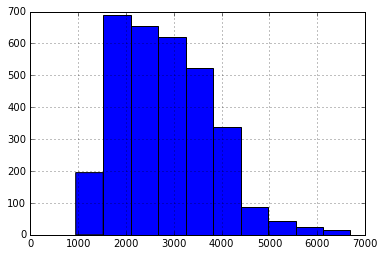

In [57]:
aux[~aux.isnull()].hist()

In [28]:
mat_all[mat_all['euros_m2_residencial_g'].isnull()].head(10)

CDIS CMUN CPRO CSEC       CUSEC  \
1162   10  079   28  157  2807910157   

                                               geometry censusTrack  \
1162  POLYGON ((432996.9035 4470414.5676, 432924.870...  2807910157   

      euros_m2_residencial_g  bibliotecas  bomberos  \
1162                     NaN            0         0   

                 ...               Viviendas con 7 habitaciones  \
1162             ...                                        NaN   

      Viviendas con 8 habitaciones  Viviendas con 9 o mas habitaciones  \
1162                           NaN                                 NaN   

      Total Hogares  Hogares de 1 persona  Hogares de 2 personas  \
1162          315.0                  60.0                  115.0   

      Hogares de 3 personas  Hogares de 4 personas  Hogares de 5 personas  \
1162                   60.0                   75.0                    NaN   

      Hogares de 6 o mas personas  
1162                          NaN  

[1 rows x 172 columns]

In [39]:
for i in mat_all.columns: print i

CDIS
CMUN
CPRO
CSEC
CUSEC
geometry
censusTrack
euros_m2_residencial_g
bibliotecas
bomberos
cines
colegios
farmacias
guarderias
hospitales
hoteles
monumentos
museos
parques
piscinas
pistas
policia
polideportivos
teatros
universidades
veterinarios
id_sscc
pob_tot
hombres
mujeres
< 16 anos
entre 16 y 64 anos
<64 anos
nacidos espana
nacidos eu
nacidos europa_no_eu
nacidos africa
nacidos latam
nacidos norte america
nacidos asia
nacidos oceania
nacionalidad espanola  nacidos en Espana
nacionalidad extranjera  nacidos en Espana
nacionalidad espanola  nacidos en eu
nacionalidad extranjera  nacidos en eu
nacionalidad espanola  nacidos en europa_no_eu
nacionalidad extranjera  nacidos en europa_no_eu
nacionalidad espanola  nacidos en africa
nacionalidad extranjera  nacidos en africa
nacionalidad espanola  nacidos en latam
nacionalidad extranjera  nacidos en latam
nacionalidad espanola  nacidos en norte america
nacionalidad extranjera  nacidos en norte america
nacionalidad espanola  nacidos en nor

In [49]:
mat_all['pob_tot']

0       1205
1        855
2       1795
3       1070
4       1950
5       1120
6        885
7       1235
8       1465
9       1025
10      1295
11      1855
12      1815
13      1115
14      1890
15      1330
16      1055
17      1735
18      1445
19      1375
20      1895
21       680
22       870
23       795
24       845
25      1115
26       420
27       760
28      1955
29      1575
        ... 
3155     955
3156    1590
3157    1625
3158    1325
3159    1585
3160    1215
3161    1455
3162    1265
3163    1490
3164    1080
3165     895
3166    1635
3167    1695
3168    1825
3169    1685
3170    1225
3171    1070
3172    1195
3173    1180
3174     965
3175    1045
3176    1815
3177    1420
3178    1085
3179    1580
3180    1550
3181    1265
3182    1355
3183    1940
3184    1560
Name: pob_tot, dtype: int64

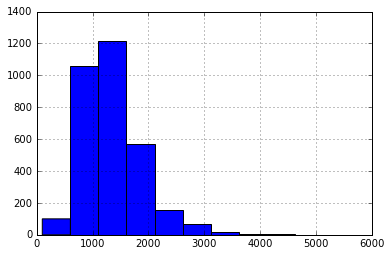

In [50]:
mat_all['pob_tot'].hist()

In [47]:
def checknull(df, columname):
    df_aux = df[df[columname].isnull()]
    print (df_aux['censusTrack'])
    print (df_aux['censusTrack']).count()

In [48]:
checknull(mat_all,'pob_tot')

Series([], Name: censusTrack, dtype: object)
0


In [58]:
mat_all[mat_all['bibliotecas']>1]

CDIS CMUN CPRO CSEC       CUSEC  \
95     01  079   28  108  2807901108   
192    02  079   28  085  2807902085   
898    08  079   28  130  2807908130   
964    09  079   28  033  2807909033   
2368   01  019   08  019  0801901019   
2372   01  019   08  025  0801901025   
2381   01  019   08  039  0801901039   
2451   02  019   08  071  0801902071   
2469   02  019   08  091  0801902091   
2748   06  019   08  001  0801906001   
2790   06  019   08  055  0801906055   
2888   07  019   08  094  0801907094   
2972   08  019   08  074  0801908074   
3009   09  019   08  005  0801909005   
3016   09  019   08  014  0801909014   
3083   10  019   08  005  0801910005   
3122   10  019   08  062  0801910062   

                                               geometry censusTrack  \
95    POLYGON ((439814.7314999998 4475595.5245, 4398...  2807901108   
192   POLYGON ((440102.9138000002 4472363.503100001,...  2807902085   
898   POLYGON ((440755.7707000002 4492214.096999999,...  2807908130   
964   POLYGON ((439305.2019999996 4478914.048900001,...  2807909033   
2368  POLYGON ((932628.3717999997 4594012.8279, 9325...  0801901019   
2372  POLYGON ((932895.8768999996 4594500.2359, 9330...  0801901025   
2381  POLYGON ((934019.5268000001 4593966.3594, 9340...  0801901039   
2451  POLYGON ((932537.8459000001 4595536.9384, 9323...  0801902071   
2469  POLYGON ((931937.4220999999 4594637.7393, 9318...  0801902091   
2748  POLYGON ((930191.8025000002 4597157.125800001,...  0801906001   
2790  POLYGON ((931509.1891 4596264.879300001, 93147...  0801906055   
2888  POLYGON ((929990.4667999996 4599497.7276, 9299...  0801907094   
2972  POLYGON ((932736.6048999997 4601244.8233, 9327...  0801908074   
3009  POLYGON ((934316.0672000004 4601911.135, 93436...  0801909005   
3016  POLYGON ((935143.4856000002 4600035.190199998,...  0801909014   
3083  POLYGON ((933238.1149000005 4597957.250999999,...  0801910005   
3122  POLYGON ((935158.3805999997 4596445.048099999,...  0801910062   

      euros_m2_residencial_g  bibliotecas  bomberos  \
95               2995.061709            6         0   
192              3611.409305            2         0   
898              2628.615102            2         0   
964              2799.229238           11         0   
2368             3091.006698            2         0   
2372             3100.856764            3         0   
2381             4234.000525            2         0   
2451             3140.258344            2         0   
2469             3400.976320            3         0   
2748             3424.827976            2         0   
2790             4072.963600            2         0   
2888             2256.352137            2         0   
2972             2495.849785            2         0   
3009             2631.081662            2         0   
3016             2900.311740            2         0   
3083             3994.112891            2         0   
3122             4493.070995            2         0   

                 ...               Viviendas con 7 habitaciones  \
95               ...                                        NaN   
192              ...                                        NaN   
898              ...                                        NaN   
964              ...                                        NaN   
2368             ...                                        NaN   
2372             ...                                        NaN   
2381             ...                                        NaN   
2451             ...                                        NaN   
2469             ...                                        NaN   
2748             ...                                        NaN   
2790             ...                                        NaN   
2888             ...                                        NaN   
2972             ...                                        NaN   
3009             ...                                        NaN   
3016     

Agrupamos variables del INE